# Исследование результатов A/B-теста

В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.   

Необходимо провести оценку корректности проведения A/B-теста и оценку его результатов.

**ЦЕЛЬ ИССЛЕДОВАНИЯ**:

1. Оценить результаты А/В-теста о внедрении улучшенной рекомендательной системы для региона EU;


2. Проверить гипотезы о равенстве долей уникальных пользователей, совершивших определенное событие, контрольной группы А и экспериментальной группы В:
*  о равенстве долей уникальных пользователей, совершивших просмотр карточки товара, контрольной группы А и экспериментальной группы В;
* о равенстве долей уникальных пользователей, совершивших просмотр корзины, контрольной группы А и экспериментальной группы В;
* о равенстве долей уникальных пользователей, совершивших покупку, контрольной группы А и экспериментальной группы В.

**ТЕХНИЧЕСКОЕ ЗАДАНИЕ**    

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**ХОД ИССЛЕДОВАНИЯ**

Данные о действиях пользователей получили из файла final_ab_events.csv.    
Вспомогательными файлами являются: final_ab_new_users.csv - о пользователях, зарегистрировавшихся с 7 по 21 декабря 2020 года, ab_project_marketing_events.csv - календарь маркетинговых событий на 2020 год; final_ab_participants.csv - таблица участников тестов.  

О качестве данных ничего не известно. Поэтому перед исследованием данных и оценкой результатов теста понадобится их обзор, предобработка и оценка теста на корректность проведения. Проверим данные на ошибки и оценим их влияние на исследование.   
Таким образом, исследование пройдёт в пять этапов:

1. Обзор и предобработка данных.   
2. Оценка корректности проведения теста. 
3. Исследовательский анализ данных.   
4. Исследование результатов эксперимента: проверка гипотез.    
5. Выводы и рекомендации.

### Обзор и предобработка данных

Импортируем необходимые библиотеки, настроим отображение таблиц и загрузим данные в переменные `events`, `users`, `marketing` и  `participants`.

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

import warnings
warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_columns', None) # настроим отображение всех столбцов на экране
pd.set_option('display.max_colwidth', None) # настроим отображение текста в ячейках
pd.set_option('display.float_format', '{:.3f}'.format) # настроим отображение вещественных чисел до 3 наков
plt.style.use('seaborn-pastel')

In [3]:
# загружаем данные
try:
    events = pd.read_csv('/datasets/final_ab_events.csv')
    users = pd.read_csv('/datasets/final_ab_new_users.csv')
    marketing = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')

except:
    events = pd.read_csv('final_ab_events.csv')
    users = pd.read_csv('final_ab_new_users.csv')
    marketing = pd.read_csv('ab_project_marketing_events.csv')
    participants = pd.read_csv('final_ab_participants.csv')

---

Для быстрого изучения данных создадим функцию `data_info`, которая выведет на экран первые 5 строк таблицы, основную инфоромацию по ней с типами данных каждого признака, информацию о числе пропусков и о количистве дубликатов.

In [4]:
def data_info(df):
    # выводим первые 5 строк датафрема
    display(df.head())
    # применяем метод info()
    print()
    print('Общая информация:')
    print(df.info())
    print()
    # считаем пропущенные значения:
    print('Число пропущенных значений:')
    print(df.isna().sum())
    print()
    # находим число строк-дубликатов в датафреме
    print('Количество строк-дубликатов:', df.duplicated().sum())

---

Поочередно применим функцию к каждому датасету и предобработаем данные в случае необходимости.

#### Датасет "events"

In [5]:
data_info(events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.990
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.990
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.990
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.990
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.990



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None

Число пропущенных значений:
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Количество строк-дубликатов: 0


<div style="border:solid Gray 1px; padding: 20px">  
    
В таблице описаны действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.    
    В таблице 4 столбца. Встречаются разные типы данных в столбцах: object и float64.     

Согласно документации:      
**user_id** — идентификатор пользователя;   
**event_dt** — дата и время события;   
**event_name** — тип события;   
**details** — дополнительные данные о событии (например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах).
  
Тип данных признака `event_dt` не соответствует заявленному описанию, для исследования понадобится привести дату к формату datetime.     
Выявлено большое число пропущенных значений в признаке `details`, с природой которых попробуем разобраться.    
Названия колонок оформлены в соответствии с хорошим стилем, явных дубликатов не обнаружено. 

Проверим какие типы событий есть в датасете, и сразу оценим наличие неявных дубликатов:

In [6]:
events['event_name'].sort_values().unique()

array(['login', 'product_cart', 'product_page', 'purchase'], dtype=object)

Пользователи совершают 4 типа событий:    

**login** - авторизация,     
**product_page** - просмотр карточки товаров,    
**product_cart** - просмотр корзины,    
**purchase** - покупка.


In [7]:
# проверим какие значения принимает признак details
events['details'].sort_values().unique()

array([  4.99,   9.99,  99.99, 499.99,    nan])

В признаке `details` неявных дубликатов тоже нет.    

Известно, что признак с пропущенными значениями `details` является дополнительными данными, поэтому кажется не обязательным; а такой высокий процент пропусков (86%) - объяснимым и допустимым.   
Но также нам известно, что для покупок в этом поле хранится их стоимость, поэтому выясним есть ли пропущенные значения именно для покупок `purchase`:

In [8]:
events[events['event_name'] == 'purchase']['details'].isna().sum()

0

Пропусков нет - для всех покупок цены указаны.    

Кроме того, проверим встречаются ли другие типы событий, по которым заполнены дополнительные данные:

In [9]:
# фильтруем датасет по заполненным значениям details и отбираем уникальные значения столбца event_name
print(events[~events['details'].isna()]['event_name'].unique())

['purchase']


Убедились, что в признаке `details` указаны данные только о цене совершенных покупок (причем цена на товары фиксированная) и среди них - пропусков нет.  Таким образом, все пропущенные значения - объяснимы, оставляем столбец без изменений.

Приведем признак `event_dt` к типу datetime.

In [10]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')
events.dtypes

user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object

Таким образом, располагаем данными о 440317 событиях.

#### Датасет "users"

In [11]:
data_info(users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None

Число пропущенных значений:
user_id       0
first_date    0
region        0
device        0
dtype: int64

Количество строк-дубликатов: 0


<div style="border:solid Gray 1px; padding: 20px">  
    
В таблице отражены пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.    
В таблице 4 столбца. Тип данных во всех столбцах: object.    

Согласно документации:      
**user_id** — идентификатор пользователя;   
**first_date** — дата регистрации;   
**region** — регион пользователя;   
**device** — устройство, с которого происходила регистрация.
  
Тип данных признака `first_date` не соответствует заявленному описанию, для исследования понадобится привести дату к формату datetime.     
Пропущенных значений нет, названия колонок оформлены в соответствии с хорошим стилем, явных дубликатов не обнаружено. 

Проверим столбцы `region` и `device` на неявные дубликаты, для этого выведем их уникальные значения на экран.

In [12]:
print('Регионы:', users['region'].unique())
print('')
print('Девайсы:', users['device'].unique())

Регионы: ['EU' 'N.America' 'APAC' 'CIS']

Девайсы: ['PC' 'Android' 'iPhone' 'Mac']


Располагаем данными о 61733 пользователях из 4 регионов, которые используют 4 вида девайсов.    
Изменим тип данных у даты регистрации:

In [13]:
users['first_date'] = pd.to_datetime(users['first_date'], format='%Y-%m-%d')
users.dtypes

user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object

#### Датасет "participants"

In [14]:
data_info(participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None

Число пропущенных значений:
user_id    0
group      0
ab_test    0
dtype: int64

Количество строк-дубликатов: 0


<div style="border:solid Gray 1px; padding: 20px">  
    
В таблице отражены участники теста. В таблице 3 столбца. Тип данных во всех столбцах: object. 

Согласно документации:      
**user_id** — идентификатор пользователя;   
**group** — группа пользователя;   
**ab_test** — название теста.   

  
Все типы данных соответствуют заявленному описанию.     
Пропущенных значений нет.   
Названия колонок оформлены в соответствии с хорошим стилем.   
Явных дубликатов не обнаружено.   

Проверим какие значения принимают признаки `group` и  `ab_test`:

In [15]:
print('Группа:', participants['group'].unique())
print('Название теста:', participants['ab_test'].unique())

Группа: ['A' 'B']
Название теста: ['recommender_system_test' 'interface_eu_test']


Неявных дубликатов нет.   
Отметитм, что данные в таблице отражены по двум тестам. Подробнее исследуем на следующем шаге.

#### Датасет "marketing"

In [16]:
data_info(marketing)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None

Число пропущенных значений:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Количество строк-дубликатов: 0


<div style="border:solid Gray 1px; padding: 20px">  
    
В таблице отражен календарь маркетинговых событий на 2020 год, содержащий 14 событий. В таблице 4 столбца. Тип данных во всех столбцах: object. 

Согласно документации:      
**name** — название маркетингового события;   
**regions** — регионы, в которых будет проводиться рекламная кампания;   
**start_dt** — дата начала кампании;   
**finish_dt** — дата завершения кампании.

  
Тип данных признаков `start_dt` и `finish_dt` не соответствует заявленному описанию, заменим на datetime.     
Пропущенных значений нет.   
Названия колонок оформлены в соответствии с хорошим стилем.   
Явных дубликатов не обнаружено.   

In [17]:
# изменяем тип данных
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'], format='%Y-%m-%d')
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'], format='%Y-%m-%d')
marketing.dtypes

name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

**Вывод**  
Данные загружены и предобработаны: типы данных заменены, где это требовалось, все заголовки оформлены в соответствии с хорошим стилем, явных и неявных дубликатов не выявлено, природа пропусков в дополнительном признаке `details` из переменной `events` понятна (признак заполнен только для действия "покупка"). Таким образом, данные готовы к следующему этапу.    
После этапа предобработки располагаем данными о 440317 событиях, о 61733 пользователях из 4 регионов, которые используют 4 вида девайсов. 

### Оценка корректности проведения теста

#### Соответствие данных требованиям технического задания

* **Название теста: "recommender_system_test"**

Из этапа предобработки мы знаем, что параллельно с нашим проводилось еще одно тестирование `'interface_eu_test'`, о котором из вводных данных ничего не известно, судя по названию - только можем предположить, что тестировался интерфейс среди пользователей региона EU.     
Отберем участников только нашего теста `'recommender_system_test'` в переменную `participants_recommender`

In [18]:
participants_recommender = participants[participants['ab_test'] == 'recommender_system_test']
print('Число участников теста "recommender_system_test":', participants_recommender.shape[0])

Число участников теста "recommender_system_test": 6701


Под тестирование новой рекомендательной системы попал 6701 пользователь.

* **Дата запуска и остановки теста**

Выведем на экран дату начала и окончания тестирования в наших данных:

In [19]:
print('Первое событие после регистрации:', events['event_dt'].min())
print('Последнее событие:', events['event_dt'].max())

Первое событие после регистрации: 2020-12-07 00:00:33
Последнее событие: 2020-12-30 23:36:33


Тест стартовал вовремя, но интересно, что последнее событие совершено 30.12.2020, в то время как тест должен был закончиться 04.01.2021.    
Из документации известно, что в `events` должны отражаться действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года, что может свидетельствовать **об ошибке на этапе сбора данных**. Таким образом, не хватает данных за 5 дней.

* **Дата остановки набора новых пользователей**

Проверим в какие сроки осуществлялся набор новых пользователей, для этого будем использовать датасет `users`:

In [20]:
print('Начало набора:', users['first_date'].min())
print('Окончание набора:', users['first_date'].max())

Начало набора: 2020-12-07 00:00:00
Окончание набора: 2020-12-23 00:00:00


Видим, что окончание набора пользователей произошло 23.12.2020 вместо 21.12.2020 (которое указано в техническом задании).   

Уберем пользователей, зарегистрированных после 21.12.2020 в соответствии с техническим заданием, результат сохраним в переменную `users_filtred`:

In [21]:
users_filtred = users[users['first_date'] <= "2020-12-21 23:59:59"]
print('Начало набора в отфильтрованных данных:', users_filtred['first_date'].min())
print('Окончание набора в отфильтрованных данных:', users_filtred['first_date'].max())

Начало набора в отфильтрованных данных: 2020-12-07 00:00:00
Окончание набора в отфильтрованных данных: 2020-12-21 00:00:00


Проверим, попали ли в наш тест пользователи с "нарушенной" датой регистрации. Для этого отфильтруем `participants_recommender` по пользователям из `users_filtred`.

In [22]:
# смотрим сколько пользователей с датой регистрации позже 2020-12-21 приняли участие в тесте
participants_recommender[~participants_recommender['user_id'].isin(users_filtred['user_id'])]

,user_id,group,ab_test


Здесь нарушений не произошло и все пользователи, принявшие участие в тесте зарегистрированы в системе в подходящие даты.

* **В тест должно быть отобрано 15% новых пользователей из региона EU**

Проверим механизм отбора пользователей в тест. Для этого из таблицы с данными о пользователях отберем клиентов из Европы, которые были зарегистрированы в даты нашего теста (то есть будем использовать `users_filtred`) и посмотрим какая доля из них попала в наш тест:

In [23]:
# отбираем пользователей из EU
users_eu = users_filtred[users_filtred['region'] == 'EU']['user_id'].nunique()

# отбираем участников теста из EU
users_test = participants_recommender.merge(users_filtred, on='user_id', how='left')
users_test_eu = users_test[users_test['region'] == 'EU']['user_id'].nunique()

#оцениваем долю попавших в тест
print('В тест отобрано: {:.2%}'.format(users_test_eu / users_eu), 'новых пользователей из региона EU')

В тест отобрано: 15.00% новых пользователей из региона EU


Механизм отбора соответствует техническому заданию.

* **Ожидаемое количество участников теста: 6000**

Проверим сколько пользователей из EU принимают участие в тесте:

In [24]:
users_test_eu

6351

На первый взгляд, число пользователей даже превышает ожидаемое число участников.

Интересно, что число пользователей из европы отличается от числа участников теста - следовательно, в  тесте приняли участие пользователи и из других регионов. Посмотрим как распределились участники теста по странам:

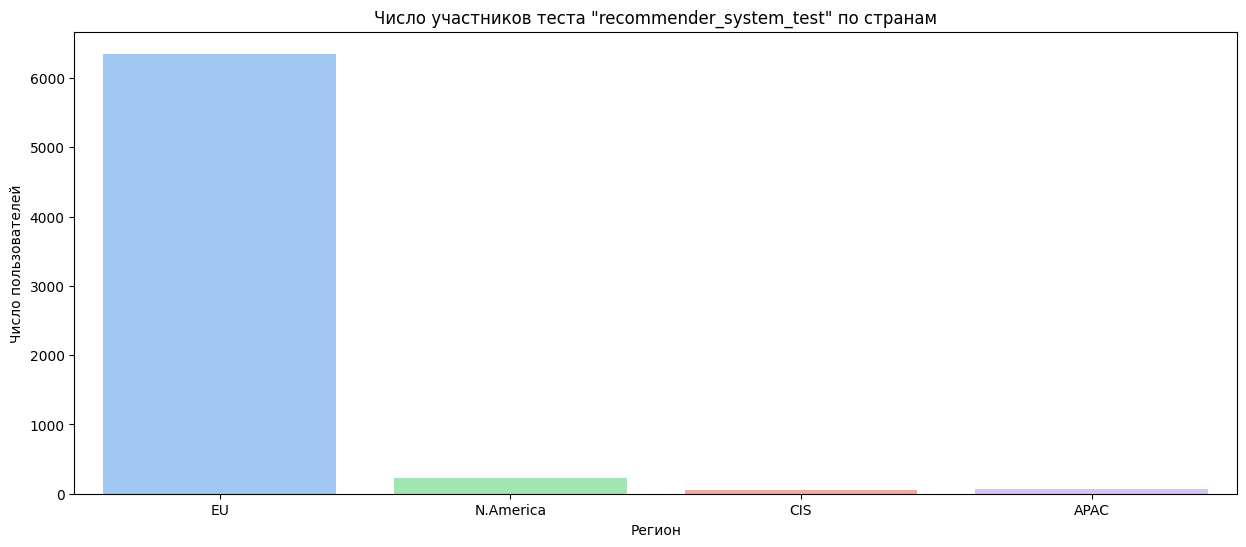

In [25]:
# строим график распределения числа участников по странам
plt.figure(figsize=(15, 6))
ax = sns.countplot(x = users_test['region'])
ax.set_title('Число участников теста "recommender_system_test" по странам')
ax.set_ylabel('Число пользователей')
ax.set_xlabel('Регион')
plt.show()

Подавляющее число пользователей, как и положено по техническому заданию из европейских стран, но 350 участников теста относятся к другим регионам. Оценим насколько критичным будет влияние таких пользователей на результаты тестирования, для этого проверим насколько равномерно распределились участники других стран между группами с помощью z-теста.    

---

Для проверки находят ли статистические критерии разницу между выборками будем использовать z-тест, который проверит гипотезы для долей.

Для простоты расчетов создадим функцию `z_test`

In [26]:
def z_test(successes, trials, alpha):
    """
    Функция принимает на вход 
    successes - массив данных, состоящий из числа "успешных" пользователей для сравниваемых групп,   
    trials - массив данных, состоящий из общего числа пользователей для сравниваемых групп,   
    alpha - уровень статистической значимости.   
   
    """
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения по формуле
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 
    
    # считаем p-value и удваиваем результат, поскольку проверка двусторонняя
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

---

Проверим гипотезу о равенстве пропорций пользователей, не относящихся к европейскому региону в группах А и В:

Сформулируем гипотезы:
```
H_0: Доли пользователей не из региона EU в группах А и В одинаковы.
H_1: Доли пользователей не из региона EU в группах А и В различаются.

```

Найдем массивы данных для проверки и проведем тест:

In [27]:
     # число уникальных пользователей 
successes = np.array([
        users_test[(users_test['region'] != 'EU') & (users_test['group'] != 'A')]['user_id'].nunique(), 
        users_test[(users_test['region'] != 'EU') & (users_test['group'] != 'B')]['user_id'].nunique()
   ])    
 
    # число уникальных пользователей в сравниваемых группах
trials = np.array([
        users_test[users_test['group'] == 'A']['user_id'].nunique(),
        users_test[users_test['group'] == 'B']['user_id'].nunique()
    ])
print('successes:', successes)
print('trials:', trials)

successes: [160 190]
trials: [3824 2877]


In [28]:
# устонавливаем уровень статистической значимости
alpha = 0.05
# применяем функцию z-test
z_test(successes, trials, alpha)
print('Доля для группы А: {0:.1%}'.format(successes[0]/trials[0]))
print('Доля для группы B: {0:.1%}'.format(successes[1]/trials[1]))

p-value:  1.0473313185821453e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница
Доля для группы А: 4.2%
Доля для группы B: 6.6%


Пользователи по группам распределились не достаточно равномерно, поэтому в исследовании оставим только тех, кто относится к региону EU.

In [29]:
users_test = users_test[users_test['region']=='EU']

# отфильтруем участников теста по региону
participants_recommender = participants_recommender[participants_recommender['user_id'].isin(users_test['user_id'])]
participants_recommender.shape[0]

6351

* **ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%**

Улучшение и сравнение самих метрик уже будет рассмотренно непосредственно на этапе исследовательского анализа.     

Для того, чтобы оценить корректность проведения теста по этому пункту важно ограничить события по лайфтайму, равному 14 дням, а также разобраться как поступить с пользователями, которые физически не имели возможности "прожить" до 14 дней. Считаем разумным провести такую оценку после полного изучения и фильтрации аудитории теста в следующем пункте.

#### Аудитория  теста

Проверим сколько всего пользоваелей, зарегистрированных с 7 по 21 декабря 2020 года:

In [30]:
print('Число пользователей, зарегистрированных с 7 по 21 декабря 2020: ', users_filtred.shape[0])

Число пользователей, зарегистрированных с 7 по 21 декабря 2020:  56470


Как мы уже знаем, кроме нашего тестирования проводилось еще одно. В связи с чем необходимо убедитьтся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.    

**Оценка пересечения с конкурирующим тестом**

Проверим как вообще распределились пользователи всего и по группам в обоих тестах:

In [31]:
# число уникальных участников  в двух тестах
print('Всего уникальных участников в двух тестах:', participants['user_id'].nunique())
# число уникальных участников  в нашем тесте
print('Число уникальных участников в тесте "interface_eu_test":',
      participants[participants['ab_test']=='interface_eu_test']['user_id'].nunique())
# число уникальных участников в конкурирующем тесте
print('Число уникальных участников в тесте "recommender_system_test":',
      participants[participants['ab_test']=='recommender_system_test']['user_id'].nunique())

# распределение участников по группам в разных тестах
participants.groupby(['ab_test', 'group']).agg({'user_id':'nunique'})

Всего уникальных участников в двух тестах: 16666
Число уникальных участников в тесте "interface_eu_test": 11567
Число уникальных участников в тесте "recommender_system_test": 6701


user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

Участники нашего теста распределены между группами неравномерно (разница составляет 947 человек, или 25%).

Можем заметить, что число уникальных участников в двух тестах не соответствует сумме числа участников в разных тестах, что свидетельствует о пересечении пользователей с конкурирующим тестом.    
Для того чтобы оценить насколько это может повлиять на результат тестирования отберем тех пользователей, которые попали в оба теста, результат сохраним в `double_participants`:

In [32]:
# находим список "задвоившихся" участников
double_participants_list = participants.groupby('user_id').agg({'ab_test':'nunique'}).reset_index().query('ab_test > 1')
double_participants_list = list(double_participants_list['user_id'])

# фильтруем исходные данные согласно этого списка
double_participants = participants[participants['user_id'].isin(double_participants_list)]
len(double_participants_list)

1602

**1602 пользователя приняли участие в двух тестах.**    
Мы не знаем наверняка, в какое время проводилось другое тестирование: в одно время с нашим, или в разное, поэтому риск влияния тестирования interface_eu_test на результаты тестирования recommender_system_test присутствует.   

В таком случае важно рассмотреть подробнее участников группы В конкурирующего теста, поскольку именно они видели изменения и могут повлиять на результат нашего теста (в том случае, если они тоже попали в экспериментальную группу в другом тесте), участники контрольной группы А на результаты нашего теста влияния не окажут.   
Поэтому отберем участников группы B конкурирующего теста в переменную `double_interface_B` и проверим как они распределились среди участников нашего теста.

In [33]:
# отбираем участников, которые могли повлиять на результат
double_interface_B = double_participants[
    (double_participants['ab_test'] == 'interface_eu_test') & 
    (double_participants['group'] == 'B')
]
print('Число участников группы В конкурирующего теста:', len(double_interface_B)) 

Число участников группы В конкурирующего теста: 783


Проверим как они распределились на группы в нашем тесте:

In [34]:
# отбираем среди наших участников тех, кто участвовал в группе В конкурирующего теста
double_participants_recommender = participants_recommender[
    participants_recommender['user_id'].isin(double_interface_B['user_id'])
]

# проверяем как эти участники распределились по группам нашего теста
double_participants_recommender.groupby(['ab_test','group']).agg({'user_id':'nunique'})

user_id
ab_test                 group         
recommender_system_test A          439
                        B          344

Таким образом, 344 пользователя потенциально могут оказать влияние на результаты нашего тестирования.    
В данном случае можно было бы оценить равномерность распределения участников с помощью z-теста, но с целью "чистоты" эксперимента считаем необходимым и критичным исключить из исследования участников группы В конкурирующего теста - всё-таки участники тестирования являются самым ключевым параметром и допускать возможность погрешности здесь нецелесообразно, иначе проведение тестирования вовсе может потерять смысл, а различить какой из тестов повлиял на поведение пользователя мы не сможем. 

In [35]:
# убираем из исследования пользователей группы В конкурирующего теста
participants_recommender = participants_recommender[~participants_recommender['user_id'].isin(double_interface_B['user_id'])]

print('Участников нашего теста всего:', participants_recommender.shape[0])
print('Участников нашего теста по группам:')
participants_recommender.groupby(['ab_test','group']).agg({'user_id':'nunique'})

Участников нашего теста всего: 5568
Участников нашего теста по группам:


user_id
ab_test                 group         
recommender_system_test A         3195
                        B         2373

В нашем тесте осталось 5568 пользователей вместо 6000 (по техническому заданию). Участники между группами, даже визуально, распределены неравномерно: в контрольной группе A 3195 человек, в группе В - 2373 человек (трафик разделился 57% на 43%) - разница составляет 822 человека, относительное различие количества пользователей - 25%. **Механизм деления трафика и инструмент проведения A/A-теста (в случае его проведения), вероятно, подвели**, различия в показателях - большие, что может оказать влияние на результат.

**Оценка пересечений пользователей между группами А и В внутри теста "recommender_system_test"**

Проверим не пересекаются ли пользователи между группами нашего теста:

In [36]:
(
    participants_recommender.groupby('user_id')['group'].nunique()
    .reset_index()
    .query('group > 1')['group'].count()
)  

0

Таких пользователей нет.    

**Лайфтайм**

Теперь можем вернуться к оценке лайфтайма и  добавить данные к таблице с событиями:

In [37]:
# добавляем информацию в events:
events = events.merge(participants_recommender, on = 'user_id')
events = events.merge(users_filtred, on = 'user_id')
events.head(3)

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.990,A,recommender_system_test,2020-12-07,EU,Android
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.990,A,recommender_system_test,2020-12-07,EU,Android
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android


Вычислим через сколько дней с момента регистрации произошло событите, результат сохраним в `lifetime`

In [38]:
events['lifetime'] = events['event_dt'] - events['first_date']
events.head(3)

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,lifetime
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.990,A,recommender_system_test,2020-12-07,EU,Android,0 days 06:50:29
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.990,A,recommender_system_test,2020-12-07,EU,Android,2 days 02:19:17
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,0 days 06:50:30


Отбросим все события, которые произошли позже 14 дня:

In [39]:
events = events.query('lifetime <= "14 days 00:00:00"')

Как мы знаем тест был собран не корректно и в данных не хватает информации за 5 дней, в связи с этим не все пользователи имели возможность "прожить" все 14 дней в тесте. Оценим насколько критичным это может оказаться для результатов теста. для каждого пользователя найдем время совершения первого события после регистрации, вычислим на какой день происходит событие и построим распределение числа событий по таким лайфтаймам:

In [40]:
# находим время первого события для каждого пользователя
first_event = events.groupby(['user_id']).agg({'event_dt':'min'}).reset_index()
# добавляем информацию о времени регистрации в системе
first_event = first_event.merge(users_filtred, on = 'user_id', how='left')
# находим разницу между днем регистрации и совершением первого события
first_event['difference'] = ((first_event['event_dt'] - first_event['first_date']).dt.days)+1

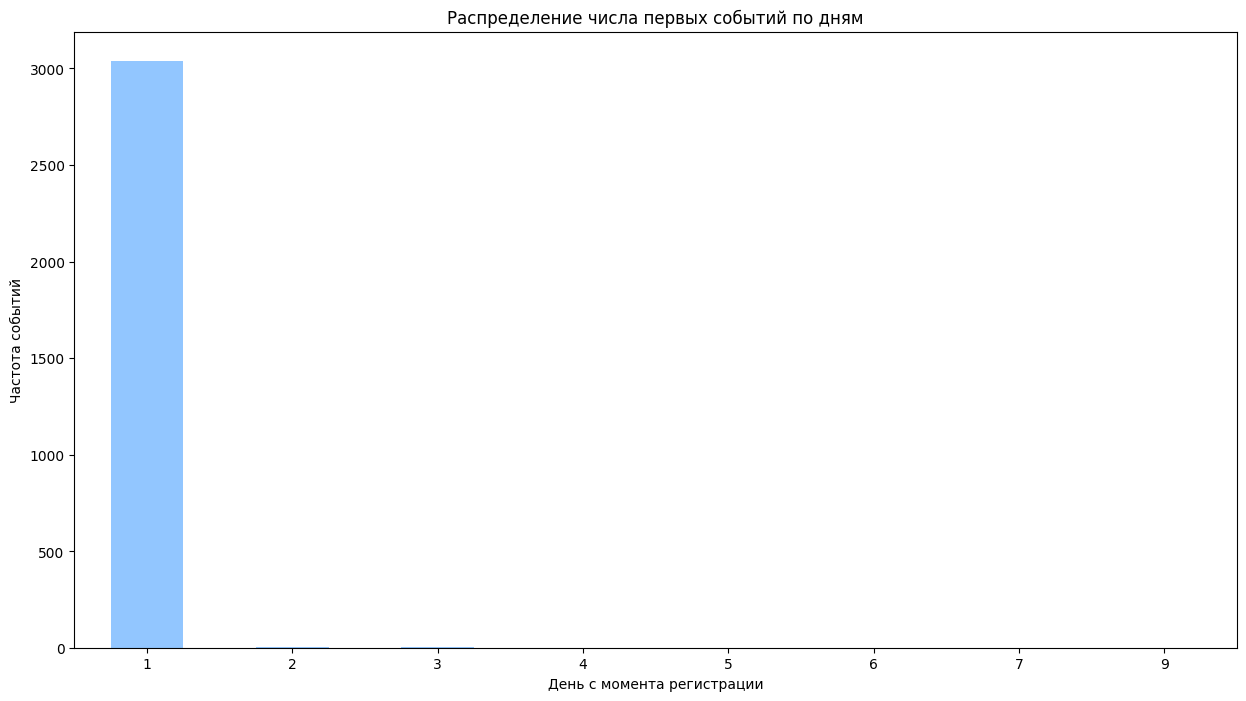

In [41]:
# визуализируем результат
first_event.groupby('difference')['user_id'].count().plot(kind='bar', figsize=(15,8))
plt.title('Распределение числа первых событий по дням')
plt.ylabel('Частота событий')
plt.xlabel('День с момента регистрации')
plt.xticks(rotation=0)
plt.show()

**Видим, что первое событие пользователя, по общему правилу, происходит в первый день с момента регистрации,**  но точно не позже 9 дня.    

Поскольку целью любого бизнеса является получение прибыли рассмотрим на какой день пользователи совершают покупку в первый раз:

In [42]:
first_event = events[events['event_name'] == 'purchase']
# находим время первого события для каждого пользователя
first_event = first_event.groupby(['user_id']).agg({'event_dt':'min'}).reset_index()
# добавляем информацию о времени регистрации в системе
first_event = first_event.merge(users_filtred, on = 'user_id', how='left')
# находим разницу между днем регистрации и совершением первого события
first_event['difference'] = ((first_event['event_dt'] - first_event['first_date']).dt.days)+1
first_event['difference'].describe()

count   953.000
mean      1.012
std       0.207
min       1.000
25%       1.000
50%       1.000
75%       1.000
max       7.000
Name: difference, dtype: float64

**Таким образом, пользователи совершают свою первую  покупку не позже, чем на 7 день.** (В большинстве случаев - на первый).  
В связи с чем допускаем, что пунктом о том, что каждый пользователь должен иметь одинаковую возможность прожить 14 дней, можем пренебречь. Как показывают данные,  первые покупки происходят не позже, чем на 7 день, а пользователи, зарегистрированные 21 декабря имели такую возможность.


Проверим сколько пользователей из отобранных в тест совершали действия в системе:

In [43]:
print('Число пользователей, отобранных для тестирования:', participants_recommender.shape[0])
print('Из них совершили события: ', events['user_id'].nunique(), 
      ' или, {0:.1%}'.format(events['user_id'].nunique()/participants_recommender.shape[0]))

Число пользователей, отобранных для тестирования: 5568
Из них совершили события:  3050  или, 54.8%


Также считаем важным, проверить как изменился % новых пользователей из региона EU после удаления пересекающихся пользователей:

In [44]:
# отбираем пользователей из EU
users_eu = users_filtred[users_filtred['region'] == 'EU']['user_id'].nunique()
# отбираем участников теста из EU
users_test = participants_recommender['user_id'].nunique()
#оцениваем долю попавших в тест
print('В тест отобрано: {:.2%}'.format(users_test / users_eu), 'новых пользователей из региона EU')

В тест отобрано: 13.15% новых пользователей из региона EU


#### Время проведения теста

Убедимся, что время проведения теста не совпадает с маркетинговыми и другими активностями.    
Определим маркетинговые события, которые пришлись на время проведения теста:

In [45]:
marketing[(marketing['start_dt'] >= dt.datetime(2020, 12, 7))]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Как видим, **во время проведения теста была проведена рекламная кампания** для европейского региона и Северной Америки, связанная с празднованием Нового года и Рождества, что могло оказать эффект на поведение экспериментальных пользователей. Попробуем выяснить насколько критично проведение промо может сказаться на результатах тестирования.   
Для этого построим график динамики числа событий в разрезе групп:

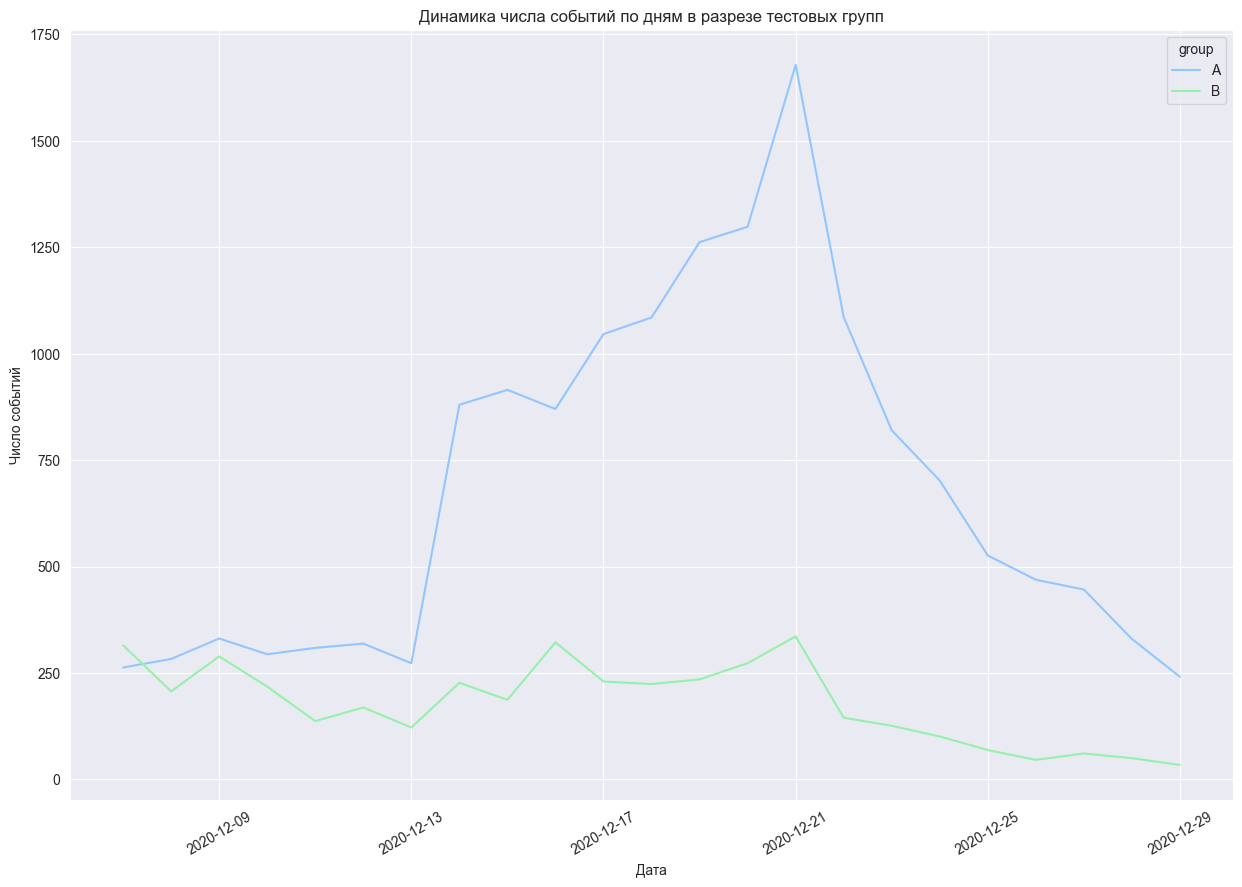

In [46]:
# выделим отдельно дату
events['dt']=events['event_dt'].dt.date

#строим график динамики событий
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')
ax = sns.lineplot(
    data = (events.groupby(['dt', 'group']).agg({'event_name':'count'})
            .reset_index()
            .rename(columns={'event_name':'quantity_events'})),
    x='dt',
    y='quantity_events',
    hue='group'
)
ax.set_title('Динамика числа событий по дням в разрезе тестовых групп')
ax.set_ylabel('Число событий')
ax.set_xlabel('Дата')
plt.xticks(rotation=30)
plt.show()

Отмечается всплеск действий пользователей 21.12.2020 в обеих группах, но мы не можем связать его с проведением рекламной кампании (тут - что-то другое).     
Из графика следует, что положительных результатов в числе действий пользователей рекламная кампания не обеспечила. После начала проведения (25 декабря 2020) - наблюдается, наоборот, постепенное снижение числа событий.    
Таким образом, в исследовании можем пренебречь проведением данной акции.

**ВЫВОД**   

**Тестирование было проведено с нарушениями.** Пункты технического задания противоречат друг другу, поэтому произведена оценка критичности несоответсвия каждому пункту. В случае критичного несоответствия - пункты технического задания подверглись коррекции. Таким образом, в результате получили:     

* Тест остановлен 30.12.2020, вместо положенного 04.01.2021. В данных отсутствует информация за 5 дней;   
* Набор участников продолжался до 23.12.2020, поэтому данные отфильтрованы в соответствии с техническим заданием - в исследование попали пользователи, зарегистрированные в системе до 21 декабря 2020;   
* Вместе с нашим проводился еще один тест "interface_eu_test", участники которого пересеклись с нашими участниками. В связи с чем принято решение об удалении участников группы B теста-конкурента;    
* Кроме того, в состав участников нашего теста попали 350 представителей других регионов (не EU), которые распределились по группам тестирования не равномерно - в связи с чем было принято решение об их исключении;    
* Механизм отбора в тест новых пользователей из региона EU, в целом работает корректно! (доля таких пользователей составляет 15% как этого требует техническое задание). Но стоит отметить, что после исключения пользователей группы В конкурирующего теста в нашем случае этот показатель снизился до 13,15%;    
* После всех фильтраций соответствия пунктам ТЗ - тестированию подлежит 5568 пользователей, вместо заявленных 6000, из них только 55% пользователей (3050 человек) совершили какие-то события после регистрации;    
* Данные пользователи распределились на группы неравномерно: в контрольной группе A 3195 человек, в группе В - 2373 человек (трафик разделился 57% на 43%) - разница составляет 822 человека, относительное различие количества пользователей - 25%. В то время как для успешного проведения теста количество пользователей в группах не должно превышать 1% - механизм деления трафика работает не корректно, и вероятность ошибки высока.  Проверив результаты деления групп на калькуляторе расчета минимальной выборки, пришли к выводу, что для подтверждения результата различия групп с вероятностью в 95% - участников в минимальной группе не хватает (для этого их должно быть 2400, у нас - 2373), таким образом, в случае подтверждения различий в поведениях групп сможем говорить об этом только с 90-% вероятностью;    
* Во время проведения теста, когда набор пользователей был уже остановлен была проведена маркетинговая кампания "Christmas&New Year Promo" для пользователей из EU. В результате дополнительных проверок установлено, что она не повлияла на поведение пользователей.   

Все выше перечисленные пункты подвергнут сомнению полученные результаты, поскольку являются весомым поводом для искажения результата.

### Исследовательский анализ данных

#### Распределение количества событий на пользователя

Проверим как распределились пользователи, совершавшие события, по группам и число событий:

In [47]:
# число уникальных пользователей, совершивших события
groups_users = events.groupby('group').agg({'user_id': 'nunique'}).reset_index().rename(columns={'user_id':'users'})
groups_users

,group,users
0,A,2279
1,B,771


In [48]:
# число событий, совершенных пользователями в разрезе групп
events.groupby('group').agg({'user_id': 'count'})

,user_id
group,
A,15726
B,4123


В группе А пользователи примерно в три раза активнее, чем в группе В. Число пользователей в группах кажется не соизмеримым.

Оценим количество событий на пользователя в общем и в разрезе по группам:

Общее описание данных:


count   3050.000
mean       6.508
std        3.732
min        1.000
25%        4.000
50%        6.000
75%        9.000
max       24.000
Name: quantity, dtype: float64

Среднее значение группы А: 6.9 Медианное значение группы А: 6.0
Среднее значение группы B: 5.3 Медианное значение группы B: 4.0


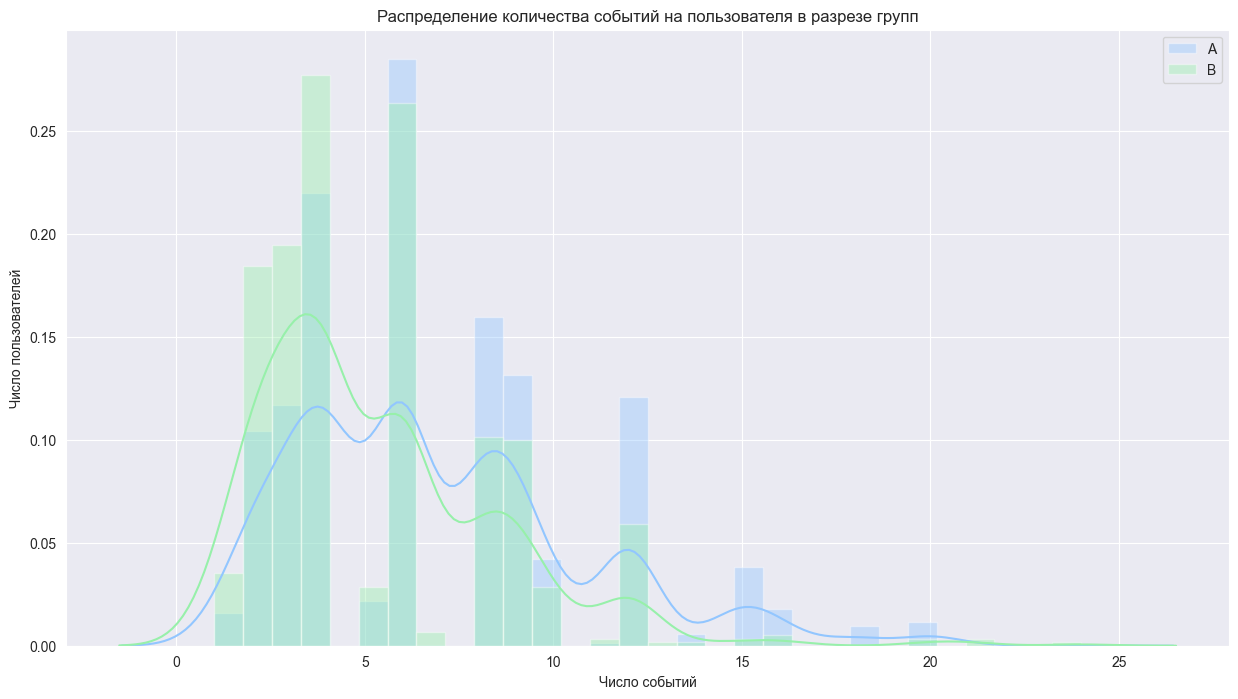

In [49]:
# посчитаем сколько событий в общем производит каждый пользователь и выведем описательные статистики по показателю
print('Общее описание данных:')
display((
    events.groupby('user_id').agg({'event_name': 'count'})
    .reset_index()
    .rename(columns={'event_name':'quantity'})
)['quantity'].describe())

# cделаем срез по каждой группе
user_a = (
    events[events['group'] == 'A'].groupby('user_id').agg({'event_name': 'count'})
    .reset_index()
    .rename(columns={'event_name':'quantity'})
)
user_b = (
    events[events['group'] == 'B'].groupby('user_id').agg({'event_name': 'count'})
    .reset_index()
    .rename(columns={'event_name':'quantity'})
)
# выведем средние значения числа событий на пользователя по группам
print('Среднее значение группы А: {0:.1f}'.format(
    user_a['quantity'].mean()), 'Медианное значение группы А:', user_a['quantity'].median())

print('Среднее значение группы B: {0:.1f}'.format(
    user_b['quantity'].mean()), 'Медианное значение группы B:', user_b['quantity'].median())

# построим распределения числа событий на пользователя в разрезе тестируемых групп
plt.figure(figsize=(15, 8))
ax = sns.distplot(user_a['quantity'], bins=30, label='A')
ax = sns.distplot(user_b['quantity'], bins=30, label='B')
plt.title('Распределение количества событий на пользователя в разрезе групп')
plt.xlabel('Число событий')                  
plt.ylabel('Число пользователей')     
plt.legend()
plt.show()

Пользователи в целом, совершают от 1 до 28 событий. Причем **у половины пользователей группы B число событий не превышает 5, а в группе А - 6.**    
Число событий на пользователя в группе В (5,7) ниже, чем в группе А (7,1).  Что также подтверждает то, что **пользователи группы А более активны.**

#### Распределение числа событий в выборках по дням

In [50]:
# считаем число совершенных событий по датам в разрезе групп
events_dt_a = events[events['group'] == 'A'].groupby('dt')['event_name'].count()
events_dt_b = events[events['group'] == 'B'].groupby('dt')['event_name'].count()

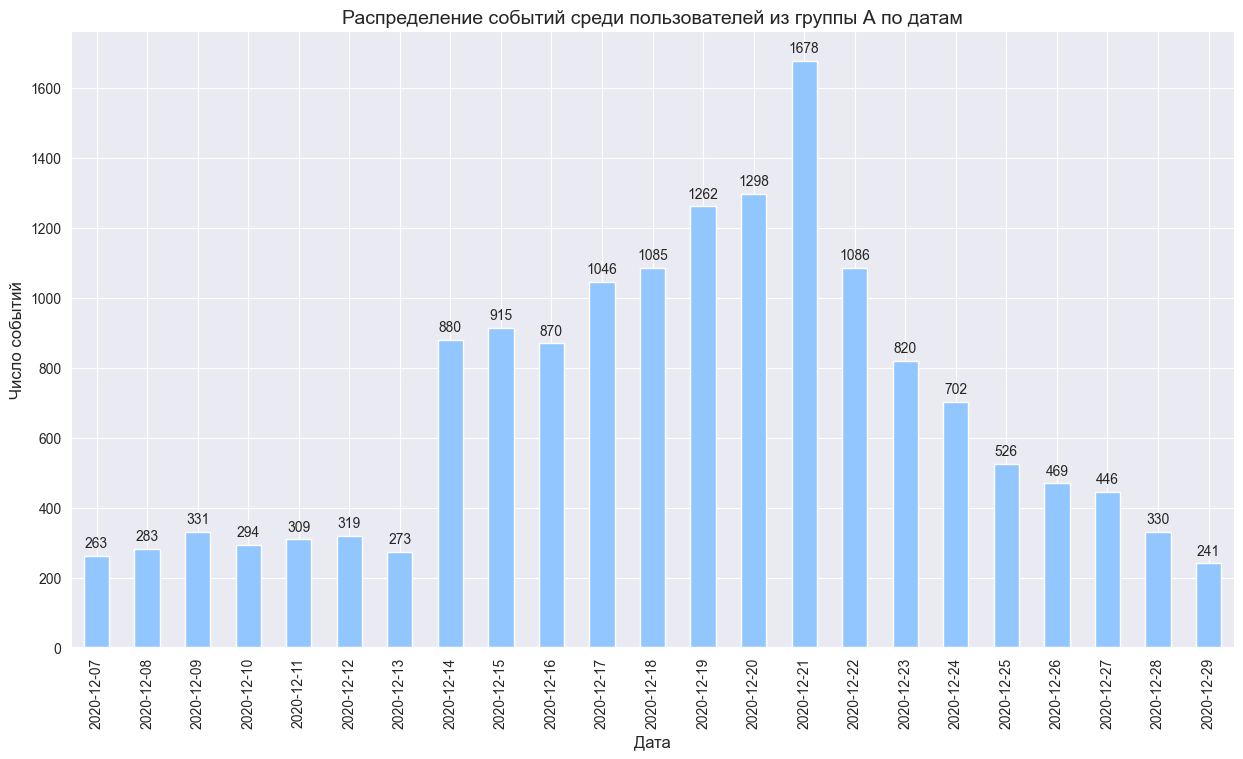

In [51]:
# строим распределение числа событий в группе А
plt.figure(figsize=(15, 8))
ax = events_dt_a.plot(kind='bar')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax.set_title('Распределение событий среди пользователей из группы А по датам', fontsize=14)
ax.set_xlabel('Дата', fontsize=12)
ax.set_ylabel('Число событий', fontsize=12)
plt.show()

Среди пользователей группы А наблюдается резкий скачок роста событий после 13 декабря: далее происходит постепенное увеличение роста числа событий до пикового значения 1678 штук - 21 декабря 2020. В период с 19 по 21 декабря число событий достигает более 1200 штук в день. **Такой всплеск, возможно, может означать, что имеем еще и риск влияния сезонности в данных** (перед Рождественским днем 25 декабря), а вот влияния рекламной кампании 25 декабря на пользователей действительно не заметно.    
Стоит отметить, что данных за 30 декабря по контрольной группе нет.

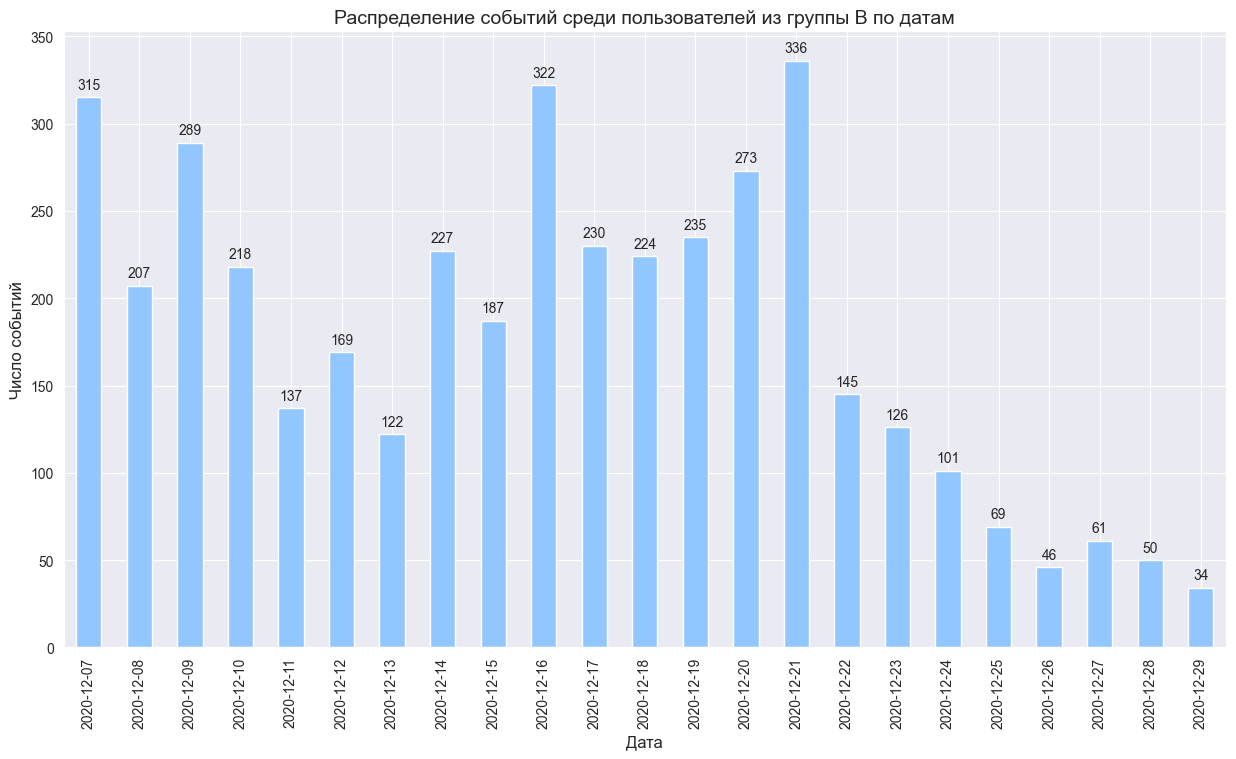

In [52]:
# строим распределение числа событий в группе В
plt.figure(figsize=(15, 8))
ax = events_dt_b.plot(kind='bar')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax.set_title('Распределение событий среди пользователей из группы B по датам', fontsize=14)
ax.set_xlabel('Дата', fontsize=12)
ax.set_ylabel('Число событий', fontsize=12)
plt.show()

Что касается группы В, то число событий по дням в разы меньше, чем в группе А. Такого резкого всплеска как в группе  А - не прослеживается - показатели постоянно подвержены колебаниям, но пик совершенных событий так же приходится на 21 декабря 2020.

#### Воронка событий

Посмотрим какие события есть и как часто они встречаются в данных:

In [53]:
# считаем число событий
print('Число событий в данных в разрезе их видов:')
display(events['event_name'].value_counts())

Число событий в данных в разрезе их видов:


login           8968
product_page    5536
purchase        2719
product_cart    2626
Name: event_name, dtype: int64

В данных представлены 4 вида событий:

**login** - авторизация (совершили 8968 раз);    
**product_page** - просмотр карточек товаров (совершили 5536 раз);      
**product_cart** - просмотр корзины (совершили 2626 раз);       
**purchase** - покупка (совершили 2719 раз).    

Интересно, что событие purchase (покупка) совершается чаще, чем product_cart (просмотр корзины). Такое возможно, если на сайте, например, есть опция покупки товара мгновенно, не переходя в корзину. Стоит уточнить этот момент у заказчиков, в случае отрицательного результата - рекомендовать обратиться в раздел разработки для проверки этого момента, в таком случае возможна и ошибка записи логов.

Найдем сколько уникальных пользователей совершили данные события:

,event_name,number_of_users,share_of_users,share_of_participants
0,login,3049,1.000,0.548
2,product_page,1905,0.625,0.342
3,purchase,953,0.312,0.171
1,product_cart,900,0.295,0.162


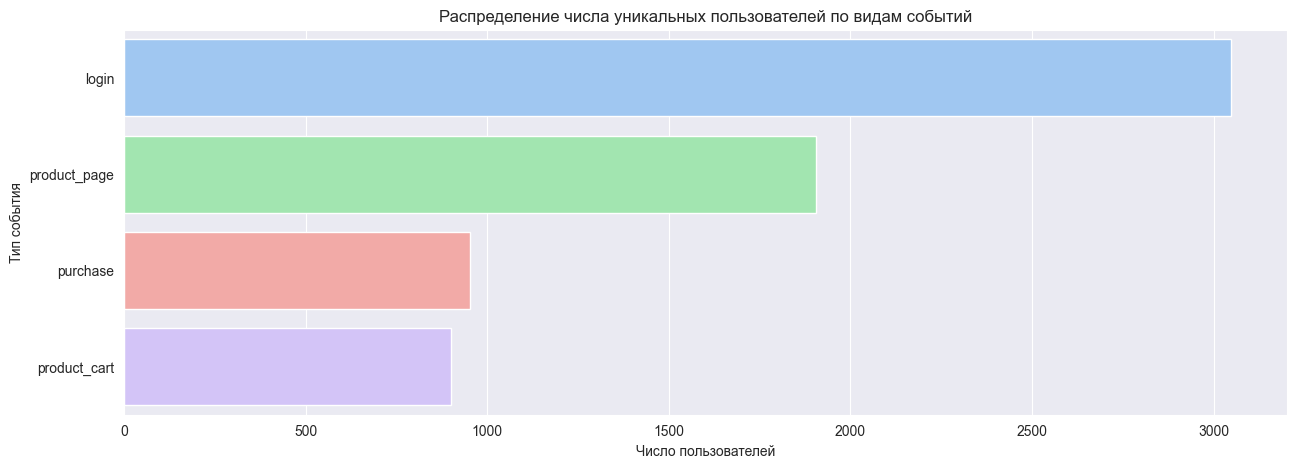

In [54]:
# группируем события по числу уникальных пользователей, совершивших их
events_for_users = (
    events.groupby(['event_name']).agg({'user_id': 'nunique'})
    .reset_index()
    .rename(columns={'user_id':'number_of_users'})
    .sort_values(by='number_of_users', ascending=False)
)
# считаем долю пользователей от уникального числа пользователей, которые совершали действия
events_for_users['share_of_users'] = events_for_users['number_of_users'] / events['user_id'].nunique()
# считаем долю пользователей от общего числа участников теста
events_for_users['share_of_participants'] = events_for_users['number_of_users'] / participants_recommender['user_id'].nunique()
display(events_for_users)

# визуализируем результат
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='number_of_users', y='event_name', data=events_for_users, orient='h')
ax.set_title('Распределение числа уникальных пользователей по видам событий')
ax.set_xlabel('Число пользователей') 
ax.set_ylabel('Тип события') 
plt.show()

До момента авторизации доходит только 54,8% зарегистрированных пользователей. Карточку товара  смотрят - 34,2%, в корзину переходит 16,2% участников, а покупку совершают 17.1% участников теста.   

Из тех, кто совершал действия на сайте все 100% пользователей авторизовались, 62,5% - посмотрели карточку товара, 29,5% - посмотрели корзину и 31,2% совершили покупку.

Понимаем, что пользователь на каждый этап воронки может попасть, минуя предыдущий, но по общему правилу, действия пользователей видятся нам в следующей последовательности: **авторизация - просмотр карточки товара - просмотр корзины - покупка**. В связи с этим принято решение строить воронку именно в такой последовательности.


Закончим подготовку данных к построению воронки, для этого расположим каждый этап воронки в нужном порядке.   
Кроме того, рассчитаем долю дошедших до определённого шага в столбце `conversion`. А также - долю перешедших с каждого шага на следующий, результат запишем в процентах в столбец `conversion_step`:

In [55]:
# выставляем события в определенной последовательности
events_for_users = events_for_users.reindex([0, 2, 1, 3])
# рассчитаем долю дошедших до определенного шага от числа пользователей на первом шаге
events_for_users['conversion'] = events_for_users['number_of_users'] / events_for_users['number_of_users'][0] * 100
# рассчитаем долю перешедших с каждого шага на следующий
events_for_users['conversion_step'] = events_for_users['number_of_users'].pct_change()*100+100
events_for_users

,event_name,number_of_users,share_of_users,share_of_participants,conversion,conversion_step
0,login,3049,1.000,0.548,100.000,NaN
2,product_page,1905,0.625,0.342,62.480,62.480
1,product_cart,900,0.295,0.162,29.518,47.244
3,purchase,953,0.312,0.171,31.256,105.889


По подготовленным данным построим воронку событий в целом по всем пользователям:

In [57]:
# строим воронку событий
fig = go.Figure(go.Funnel(
    y = events_for_users['event_name'],
    x = events_for_users['number_of_users'],
    textposition = "inside",
    textinfo = "value+percent previous",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": { "color": ["wheat", "wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(title_text='Воронка событий с отображением доли пользователей, переходящих на следующий шаг воронки')
fig.show()

Приходим к выводу, что **на этапе авторизации теряется 38% пользователей**. Возможной причиной может стать то, что пользователя не смог заинтересовать предлагаемый продукт или, например, он попал в сервис по ошибке. **Из тех, кто смотрел католог - только 47% переходит в корзину**. Таким образом, получается, что более половины пользователей просто не находят подходящий для них товар в катологе. Это, например, может быть обусловлено как неподходящей для пользователя ценой, качеством, ассортиментом, так и возможной технической проблемой, связанной с добавлением товара в корзину, поэтому стоит заострить на этом внимание и попытаться выяснить причины.  

**Лишь 31,3% от числа авторизовавшихся пользователей достигают покупки.** Из воронки следует, что оплата товара может производиться, минуя просмотр корзины.

Аналогичным образом, построим воронку событий в разрезе каждой группы. Для этого создадим вспомогательную таблицу `data`, куда соберем информацию по каждой тестовой группе:

In [58]:
# находим число пользователей, совершивших каждое событие в разрезе групп
data = (
    events.pivot_table(index='event_name', columns='group', values='user_id', aggfunc = 'nunique')
    .reset_index()
    .sort_values(by='A', ascending=False)
)
# выставляем события в определенной последовательности
data = data.reindex([0, 2, 1, 3])
# считаем долю пользователей от числа участников теста
data['share_of_participants_A'] = data['A'] / participants_recommender.query('group == "A"')['user_id'].nunique()
data['share_of_participants_B'] = data['B'] / participants_recommender.query('group == "B"')['user_id'].nunique()
data

group,event_name,A,B,share_of_participants_A,share_of_participants_B
0,login,2279,770,0.713,0.324
2,product_page,1476,429,0.462,0.181
1,product_cart,686,214,0.215,0.090
3,purchase,734,219,0.230,0.092


В группе А авторизуется 71,3% зарегистрированных пользователей, а в группе В - только 32,4%.

In [59]:
# Строим воронку событий по тестируемым группам
fig = go.Figure()

#оформляем блоки по группе A
fig.add_trace(go.Funnel(
    name = 'А',
    y = data['event_name'],
    x = data['A'],
    opacity = 0.65, marker = {"color": ["deepskyblue", "deepskyblue", "deepskyblue", "deepskyblue", "silver"]},
    textinfo = "value+percent previous"))

#оформляем блоки по группе B
fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = data['event_name'],
    x = data['B'],
    textposition = "inside",
    opacity = 0.65, marker = {"color": ["lightsalmon", "lightsalmon", "lightsalmon", "lightsalmon", "silver"]},
    textinfo = "value+percent previous"))
fig.update_layout(
    title_text='Воронка событий в разрезе тестовых групп')
fig.show()

Тестовая группа В менее активна в числе событий, чем контрольная группа А на каждом шаге воронки.   
По воронке можем заметить, что, в целом, группа А конвертируется от шага к шагу лучше, чем группа В, только на этапе перехода от просмотра товара к корзине у группы В конверсия выше.   

В группе А показатели перехода к просмотру карточки товаров лучше, чем в группе В. На страницу товара заходят 65% авторизовавшихся пользователей группы А (теряется - 35%), в группе В на страницу товара заходят 56% (44% уходят с сайта). Возможно, обновленная рекомендательная система не справляется с запросами пользователя и не заинтересовавшись предложениями пользователь выходит.    

Также наблюдается "нарушение" последовательности действий: в обоих группах число совершенных покупок выше, чем число просмотров корзины. Таким образом, последовательность событий, которую мы ожидали увидеть - не прослеживается ни в одной из групп.   

**Конверсия в покупку также выше в группе А: 32,2% пользователей от числа авторизованных совершают покупку, в то время как для группы В этот показатель составляет 28,4%.**    

Кроме того, стоит отметить, что не на одном этапе воронки не достигнут ожидаемый эффект: прироста 10% по ключевым метрикам на разных этапах воронки в группе В по сравнению с группой А не наблюдается.



#### Особенности данных

Прежде, чем приступать к А/В-тестированию стоит учитывать, что тест во многом, был проведен не корректно и полученные результаты лучше перепроверять.        
* Важной и одной из главных особенностей данных и грубым нарушением является некорректное деление трафика теста: для достижения наилучшего результата стоит делить пользователей на равные группы 50 на 50, в нашем случае - деление 57% на 43%.
* Тест не проведен полностью, в целом фактически располагаем данными по 29.12.2020, данные за 30 декабря есть только по группе В, и их совсем мало.
* Количество участников меньше нужных 6000.  
* В процессе исследования обнаружен всплеск активности контрольной группы А в период с 14 декабря 2020 с пиковыми значениями 21 декабря, что может свидетельствовать о влиянии сезонного фактора на данные. Тестовая группа В идентичной тенденции не показала, не смотря на пик значений тоже 21 декабря.   
* Воронка событий не соответствует ожидаемой.

**Вывод**     

Из 5568 участников теста после регистрации события совершали лишь 3050 пользователей: 2279 - из группы А, 771 - из группы В.   

Проанализировав число совершенных событий каждым пользователем, приходим к выводу, что пользователи в группе А примерно в 3 раза активнее, чем в группе В.    
    Пользователи в целом совершают от 1 до 28 событий, у половины пользователей группы В число событий не превышает 5, а в группе А - 6 штук. В среднем, число событий на пользователя в группе А выше, чем в группе В (7,1 против 5,7).   
    
При рассмотрении числа событий по дням в группе А замечен резкий скачок числа событий после 13 декабря 2020 с пиком 21 декабря, что может говорить о риске влияния сезонности на данные. Максимальное число событий за день в группе А - 1678 штук. Явной аналогичной тенденции в распределении числа событий группы В не отмечается, однако, пик событий приходится также на 21 декабря. Максимальное число событий группы В - 336 штук.   

При построении воронки событий выяснено, что ожидаемая последовательность: "авторизация - просмотр карточки товаров - просмотр корзины - покупка" может быть нарушена. Зафиксировано, что число покупок больше числа просмотров корзины в каждой из групп, что может, говорить, например, о наличии покупок "в один клик".   
Поэтапная конверсия группы А, в целом, лучше конверсии группы В. От числа авторизовавшихся пользователей покупателями становятся 32,2% пользователей, а в группе В - 28,4%.


### Оценка результатов A/B-тестирования

Считаем, что данное тестирование нельзя считать полезным, а его результаты корректными.  
Во-первых, данные собраны не корректно - не за весь период.   
Во-вторых, пользователи некорректно разделены на группы.   
В-третьих, многие пункты ТЗ скорректированы.   
В-четвертых, ожидаемого прироста в 10% ключевых метрик не достигнуто. 

В связи с чем было бы полезным скорректировать механизмы проведения теста и повторить его с учетом расписания маркетинговых кампаний.

**Проверка гипотез**

Оценим есть ли статистически значимая разница между долями пользователей, прошедших по воронке, в группах А и В.


Сформулируем гипотезы:    

${H_0}$: *Доли уникальных пользователей, совершивших определенное событие, контрольной группы А и экспериментальной группы В равны.*

${H_1}$: *Доли уникальных пользователей, совершивших определенное событие, контрольной группы А и экспериментальной группы В не равны.*


Для оценки будем использовать созданную ранее функцию `z-test`. Для создания массива данных создадим дополнительную функцию `z_event_array`

In [60]:
# функция для создания массива с числом успехов и с общим числом пользователей для сравниваемых групп по виду события
def z_event_array(event):
    '''    
Функция предназначена для создания массива данных для z-тестирования, принимает аргументы:    
**event** - наименование события    
    '''       
     # число уникальных пользователей, совершивших событие в сравниваемых группах
    successes = np.array([
        data[data['event_name'] == event]['A'],
        data[data['event_name'] == event]['B']
    ])    
 
    # число уникальных пользователей в сравниваемых группах
    trials = np.array([
        groups_users[groups_users['group'] == 'A']['users'], 
        groups_users[groups_users['group'] == 'B']['users']
    ])
    return successes, trials

Применим к каждому виду событий комбинацию из двух функций.    
Но стоит отметить, что по мере увеличения количества статистических тестов вероятность совершения ошибки первого рода быстро возрастает (то есть растет вероятность не верно отвергнуть ${H_0}$), чтобы контролировать вероятность совершения ошибки и увеличить точность теста скорректируем уровень статистической значимости через поправку Бонферрони:

In [61]:
# вводим поправку Бонферрони
alpha = .05/3

# переберем циклом каждое событие за исключением и применим к ним функцию z_test
for event in ['product_page', 'product_cart', 'purchase']:
    print(event)
    successes, trials = z_event_array(event)
    print('Конверсия группы А:', successes[0]/trials[0]*100)
    print('Конверсия группы B:', successes[1]/trials[1]*100)
    print(successes[0], successes[1],trials[0] , trials[1])
    z_test(successes, trials, alpha)
    print('')
    print('')

product_page
Конверсия группы А: [64.76524792]
Конверсия группы B: [55.64202335]
[1476] [429] [2279] [771]
p-value:  [6.12073063e-06]
Отвергаем нулевую гипотезу: между долями есть значимая разница


product_cart
Конверсия группы А: [30.10092146]
Конверсия группы B: [27.75616083]
[686] [214] [2279] [771]
p-value:  [0.21721123]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


purchase
Конверсия группы А: [32.20710838]
Конверсия группы B: [28.40466926]
[734] [219] [2279] [771]
p-value:  [0.0489426]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Таким образом, статистически значимые различия выявлены только для конверсий в просмотр карточки товара между группами А и В. По остальным событиям не получилось отвергнуть нулевую гипотезу - статистически значимого различия в долях между группами нет. Но стоит отметить, что в силу нарушений проводимого теста, результат может быть искажен.

### Общие выводы по исследованию

В процессе исследования были выявлены **критические нарушения в проведении теста:**     
* Данные были собраны не за полный период, получается тест был остановлен за 5 дней до предполагаемого окончания;   
* Вместе с нашим проводился еще один тест в связи с чем произошло пересечение участников двух тестов;    
* Распределение трафика на группы внутри теста происходит не корректно (в нашем случае трафик разделился 57% на 43%, относительное различие количества пользователей - 25%) при необходимом уровне в 1%;    
* Во время проведения теста была запущена маркетинговая кампания (в нашем случае сильного влияния она не оказала).    

**Исследовательский анализ данных показал**:

* Из 5568 участников теста после регистрации события совершали лишь 3050 пользователей: в группе А авторизовались 71% зарегистрированных участников теста (2279 чел.), в группе В - лишь 32% (771 чел).    
* Пользователи в группе А примерно в 3 раза активнее, чем в группе В.   
* В среднем, число событий на пользователя в группе А выше, чем в группе В (7,1 против 5,7).
* На результаты исследования могут оказывать влияние сезонные всплески активности пользователей, выявленные в районе 21 декабря.    
* При построении воронки событий выяснено, что ожидаемая последовательность: "авторизация - просмотр карточки товаров - просмотр корзины - покупка" может быть нарушена.    
* Поэтапная конверсия группы А, в целом, лучше конверсии группы В. От числа авторизовавшихся пользователей покупателями становятся 32,2% пользователей, а в группе В - 28,4%.     
* Не на одном этапе воронки не достигнут ожидаемый эффект тестирования: прироста 10% по ключевым метрикам на разных этапах воронки в группе В по сравнению с группой А не наблюдается.   

**Оценка результатов A/B-тестирования выявила:**      
Статистически значимые различия только для конверсий в просмотр карточки товара между группами А и В. По остальным событиям статистически значимого различия в долях между группами не было выявлено. Но в силу нарушений проводимого теста, результат может быть искажен. 

**Заключение:**  
Тестирование нельзя считать полезным, а его результаты корректными.   
По имеющимся для анализа данным, которые изначально являются сомнительными - внедрение новой рекомендательной системы не повлекло за собой повышения целевых показателей.   

**Рекомендации:**    
Для более достоверной оценки улучшения целевых показателей рекомендуем:   
* отрегулировать механизмы деления трафика,    
* проанализировать причины неполного сбора данных и устранить их,  
* не проводить несколько тестирований одновременно, либо более тщательно подходить к механизму отбора пользователей в разные тесты,
* постараться выбирать даты тестирования таким образом, чтобы исключить влияние сезонных событий;     
* повторить тестирование, убедившись в отстутствии маркетинговых кампаний.
